In [10]:
# Part one: Data Preprocessing
# Basic preprocessing method include encoding y labels using LabelEncoder, spliting training and testing data and standardizing to ensure everyone's preprocessed data aligned with each other.
# Since there is no missing values in the dataset, we don't need to do any imputation.
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_excel('Dry_Bean_Dataset.xlsx')

X = data.drop(columns = ['Class'])
y = data['Class']

# label_encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the class numbers and the correspond class names
print("Class numbers:", np.unique(y_encoded))
print("Class names:", label_encoder.classes_)

# train_test_split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Class numbers: [0 1 2 3 4 5 6]
Class names: ['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']


In [3]:
# Part one: Data Preprocessing
# Advanced preprocessing method include remove outliers, add noise and augment data
def remove_outliers_iqr(X, threshold=1.5):
    """Apply IQR method to remove outliers"""
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    mask = np.all((X >= lower_bound) & (X <= upper_bound), axis=1)
    return X[mask], mask

def add_gaussian_noise(X, mean=0.0, std=0.01):
    """Add Gaussian noise to the data"""
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

def augment_data(X, y, copies=1, noise_std=0.01):
    """Data augmentation by adding Gaussian noise and duplicating data"""
    augmented_X = [X]
    augmented_y = [y]
    for _ in range(copies):
        noisy_X = add_gaussian_noise(X, std=noise_std)
        augmented_X.append(noisy_X)
        augmented_y.append(y)
    return np.vstack(augmented_X), np.vstack(augmented_y)


train_indices = X_train.index  # 训练集样本的原始索引
test_indices = X_test.index    # 测试集样本的原始索引
X_scaled = np.empty_like(X, dtype=np.float64)

# 5. 将标准化后的数据放回对应的位置
X_scaled[train_indices] = X_train_scaled
X_scaled[test_indices] = X_test_scaled

X_no_outliers, mask = remove_outliers_iqr(X_scaled, threshold=1.5)
y_encoded_no_outliers = y_encoded[mask]
X_noisy = add_gaussian_noise(X_no_outliers, std=0.02)

X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(
    X_noisy, y_encoded_no_outliers, test_size=0.2, random_state=42
)


正在计算2D t-SNE...


C:\Users\14198\AppData\Local\Temp\ipykernel_22808\2632637205.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


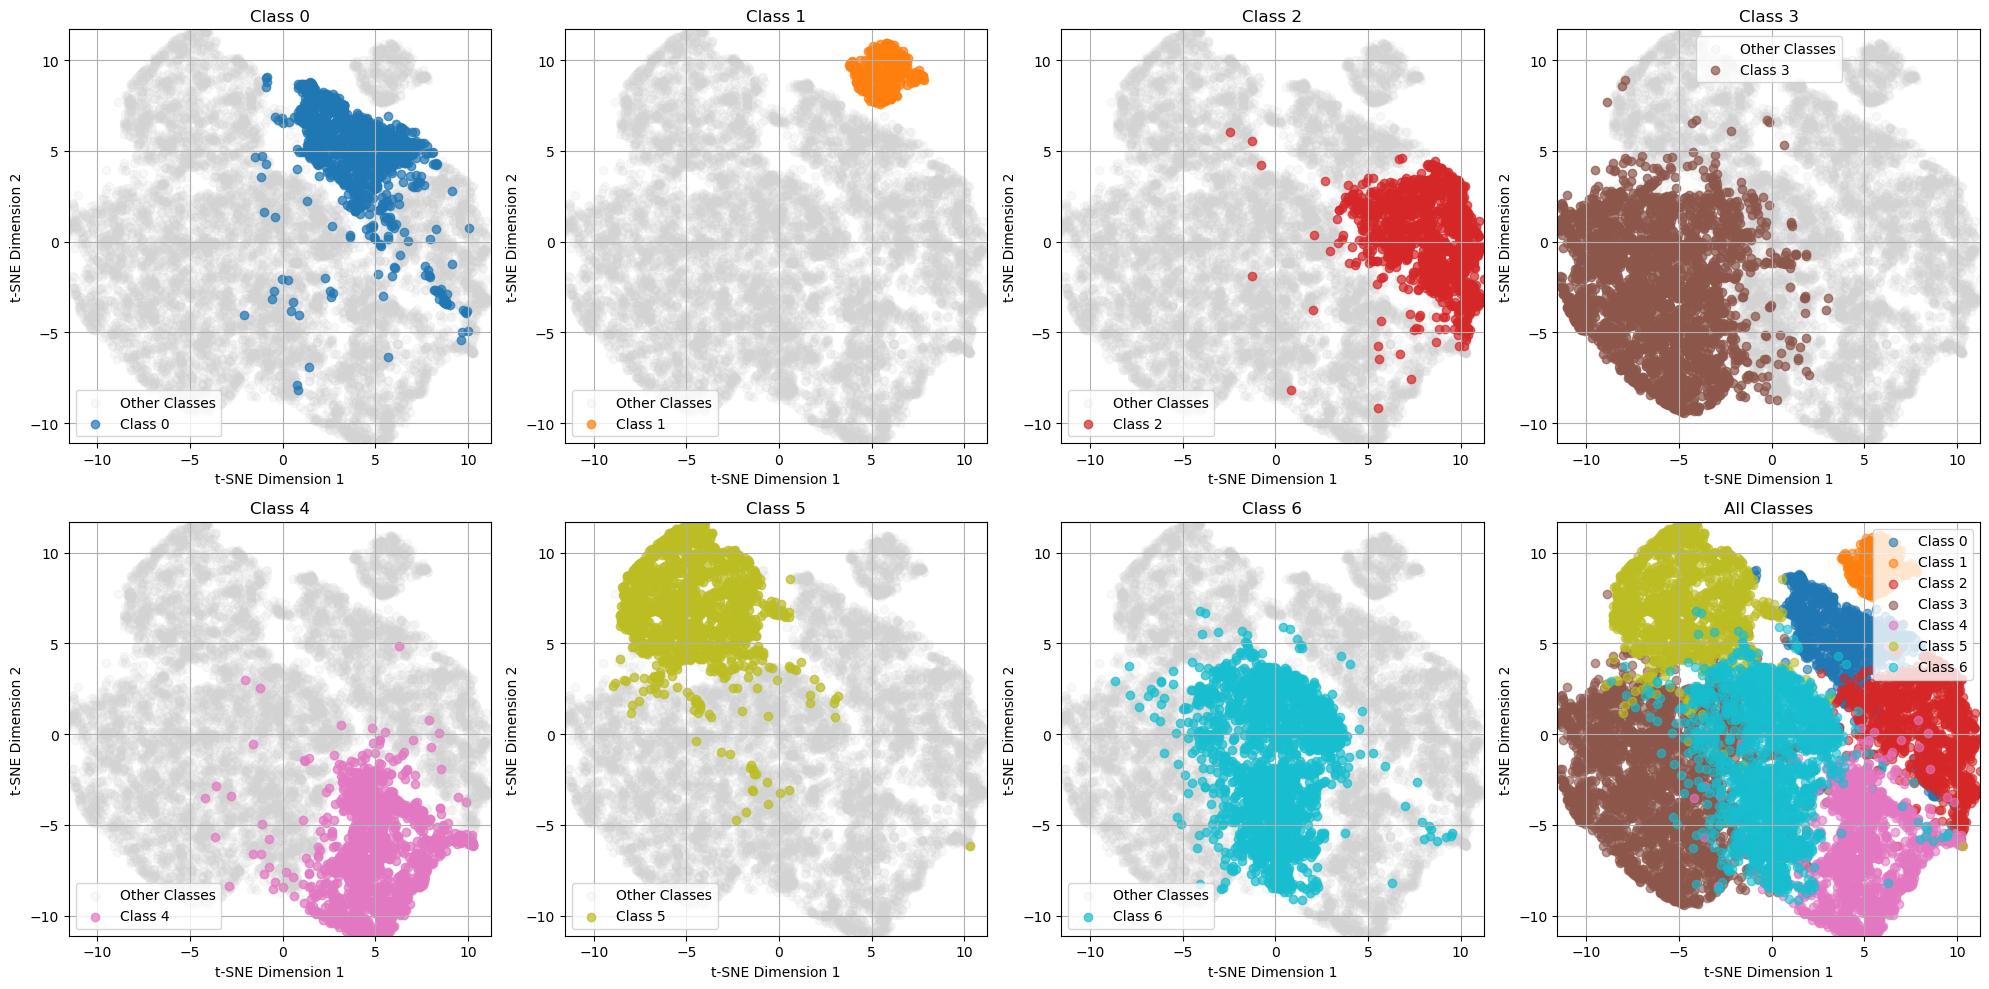

正在计算3D t-SNE...


C:\Users\14198\AppData\Local\Temp\ipykernel_22808\2632637205.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10',  len(np.unique(y_numeric)))


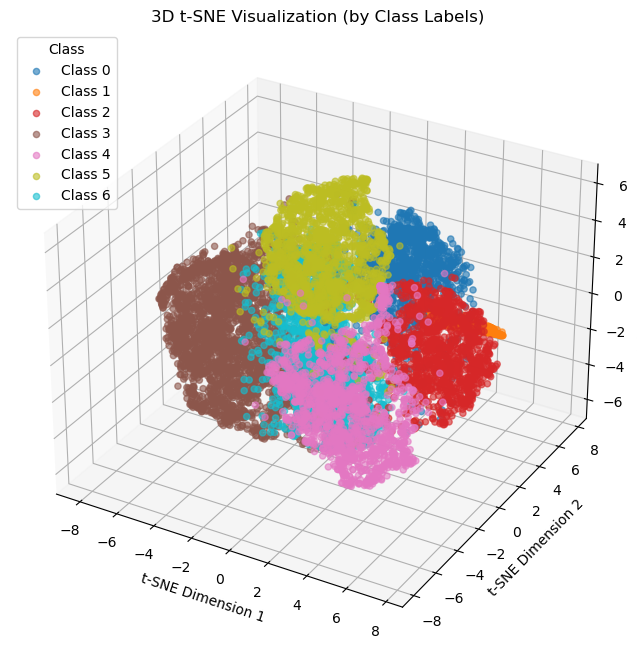

In [8]:
# Part two: Data Visualization
# Plot the t-SNE projecion using basic preprocessed data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import os

# X_train = data = np.load('../pro_data/X_train_cluster.npy')
# y_train = label = np.load('../pro_data/y_encoded_train_cluster.npy')

# can use sample data to speed up the process
# sample_size = 15000  # 可根据您的硬件调整 //10888 in total
# if len(X_train) > sample_size:
#     indices = np.random.choice(len(X_train), sample_size, replace=False)
#     X_sample = X_train_scaled[indices]
#     y_sample = y_train[indices]
# else:
#     X_sample = X_train
#     y_sample = y_train


def visualize_2d_tsne(X, y_numeric, save_path='visual_pict'):
    print("正在计算2D t-SNE...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    X_tsne_2d = tsne_2d.fit_transform(X)

    os.makedirs(save_path, exist_ok=True)

    unique_classes = np.unique(y_numeric)
    n_classes = len(unique_classes)

    # Prepare 2x4 subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    cmap = plt.cm.get_cmap('tab10', n_classes)

    # Find global axis limits for consistent scaling
    x_min, x_max = X_tsne_2d[:, 0].min(), X_tsne_2d[:, 0].max()
    y_min, y_max = X_tsne_2d[:, 1].min(), X_tsne_2d[:, 1].max()

    # Plot each class separately, but show all points in gray for context
    for i, class_label in enumerate(unique_classes):
        row, col = divmod(i, 4)
        ax = axes[row, col]
        # Plot all points in light gray
        ax.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], alpha=0.15, color='lightgray', label='Other Classes')
        # Highlight current class
        idx = y_numeric == class_label
        ax.scatter(X_tsne_2d[idx, 0], X_tsne_2d[idx, 1],
                   alpha=0.7, color=cmap(i), label=f'Class {class_label}')
        ax.set_title(f'Class {class_label}')
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.grid(True)

    # Plot the whole graph in (2,4)
    ax = axes[1, 3]
    for i, class_label in enumerate(unique_classes):
        idx = y_numeric == class_label
        ax.scatter(X_tsne_2d[idx, 0], X_tsne_2d[idx, 1],
                   alpha=0.6, color=cmap(i), label=f'Class {class_label}')
    ax.set_title('All Classes')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)

    # Hide unused subplot if n_classes < 7
    for j in range(n_classes, 7):
        row, col = divmod(j, 4)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_path}/tsne_label_2d_all.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_3d_tsne(X, y_numeric, save_path='visual_pict'):
    print("正在计算3D t-SNE...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
    X_tsne_3d = tsne_3d.fit_transform(X)

    os.makedirs(save_path, exist_ok=True)


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cmap = plt.cm.get_cmap('tab10',  len(np.unique(y_numeric)))

    for i, class_label in enumerate(np.unique(y_numeric)):
        idx = y_numeric == class_label
        ax.scatter(X_tsne_3d[idx, 0], X_tsne_3d[idx, 1], X_tsne_3d[idx, 2],
                   alpha=0.6, color=cmap(i), label=f'Class {i}')
        

    ax.set_title('3D t-SNE Visualization (by Class Labels)')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    ax.legend(title='Class', loc='upper left')
    plt.savefig(f'{save_path}/tsne_label_3d_all.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_2d_tsne(X_train_scaled, y_train)
visualize_3d_tsne(X_train_scaled, y_train) 

In [ ]:
# Part two: Data Visualization
# Interactive t-SNE visualization using Plotly
import plotly.express as px
import plotly.io as pio
import os
from sklearn.manifold import TSNE
import numpy as np

def visualize_2d_tsne_interactive(X, y_numeric, save_path='visual_pict'):
    print("2D t-SNE...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    X_tsne_2d = tsne_2d.fit_transform(X)

    os.makedirs(save_path, exist_ok=True)

    fig = px.scatter(
        x=X_tsne_2d[:, 0], 
        y=X_tsne_2d[:, 1], 
        color=[str(label) for label in y_numeric],
        labels={'color': 'Class'},
        hover_name=[f"Sample {i} - Class {label}" for i, label in enumerate(y_numeric)],
        title="2D t-SNE Interactive Visualization",
        color_discrete_sequence=px.colors.qualitative.Dark24
    )
    
    fig.update_layout(
        width=900,
        height=700,
        template="plotly_white"
    )

    fig.show()


def visualize_3d_tsne_interactive(X, y_numeric, save_path='visual_pict'):
    print("3D t-SNE...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
    X_tsne_3d = tsne_3d.fit_transform(X)

    os.makedirs(save_path, exist_ok=True)

    fig = px.scatter_3d(
        x=X_tsne_3d[:, 0],
        y=X_tsne_3d[:, 1],
        z=X_tsne_3d[:, 2],
        color=[str(label) for label in y_numeric],
        labels={'color': 'Class'},
        hover_name=[f"Sample {i} - Class {label}" for i, label in enumerate(y_numeric)],
        title="3D t-SNE Interactive Visualization",
        color_discrete_sequence=px.colors.qualitative.Dark24
    )
    
    fig.update_layout(
        width=1000,
        height=800,
        template="plotly_white"
    )

    # fig.write_html(f"{save_path}/tsne_3d_interactive.html")
    fig.show()


visualize_2d_tsne_interactive(X_train_scaled, y_train)
visualize_3d_tsne_interactive(X_train_scaled, y_train)


正在计算2D t-SNE...


d:\anaconda\envs\ML_PROJECT\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


正在计算3D t-SNE...


d:\anaconda\envs\ML_PROJECT\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



2D PCA...


C:\Users\14198\AppData\Local\Temp\ipykernel_22808\963221847.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


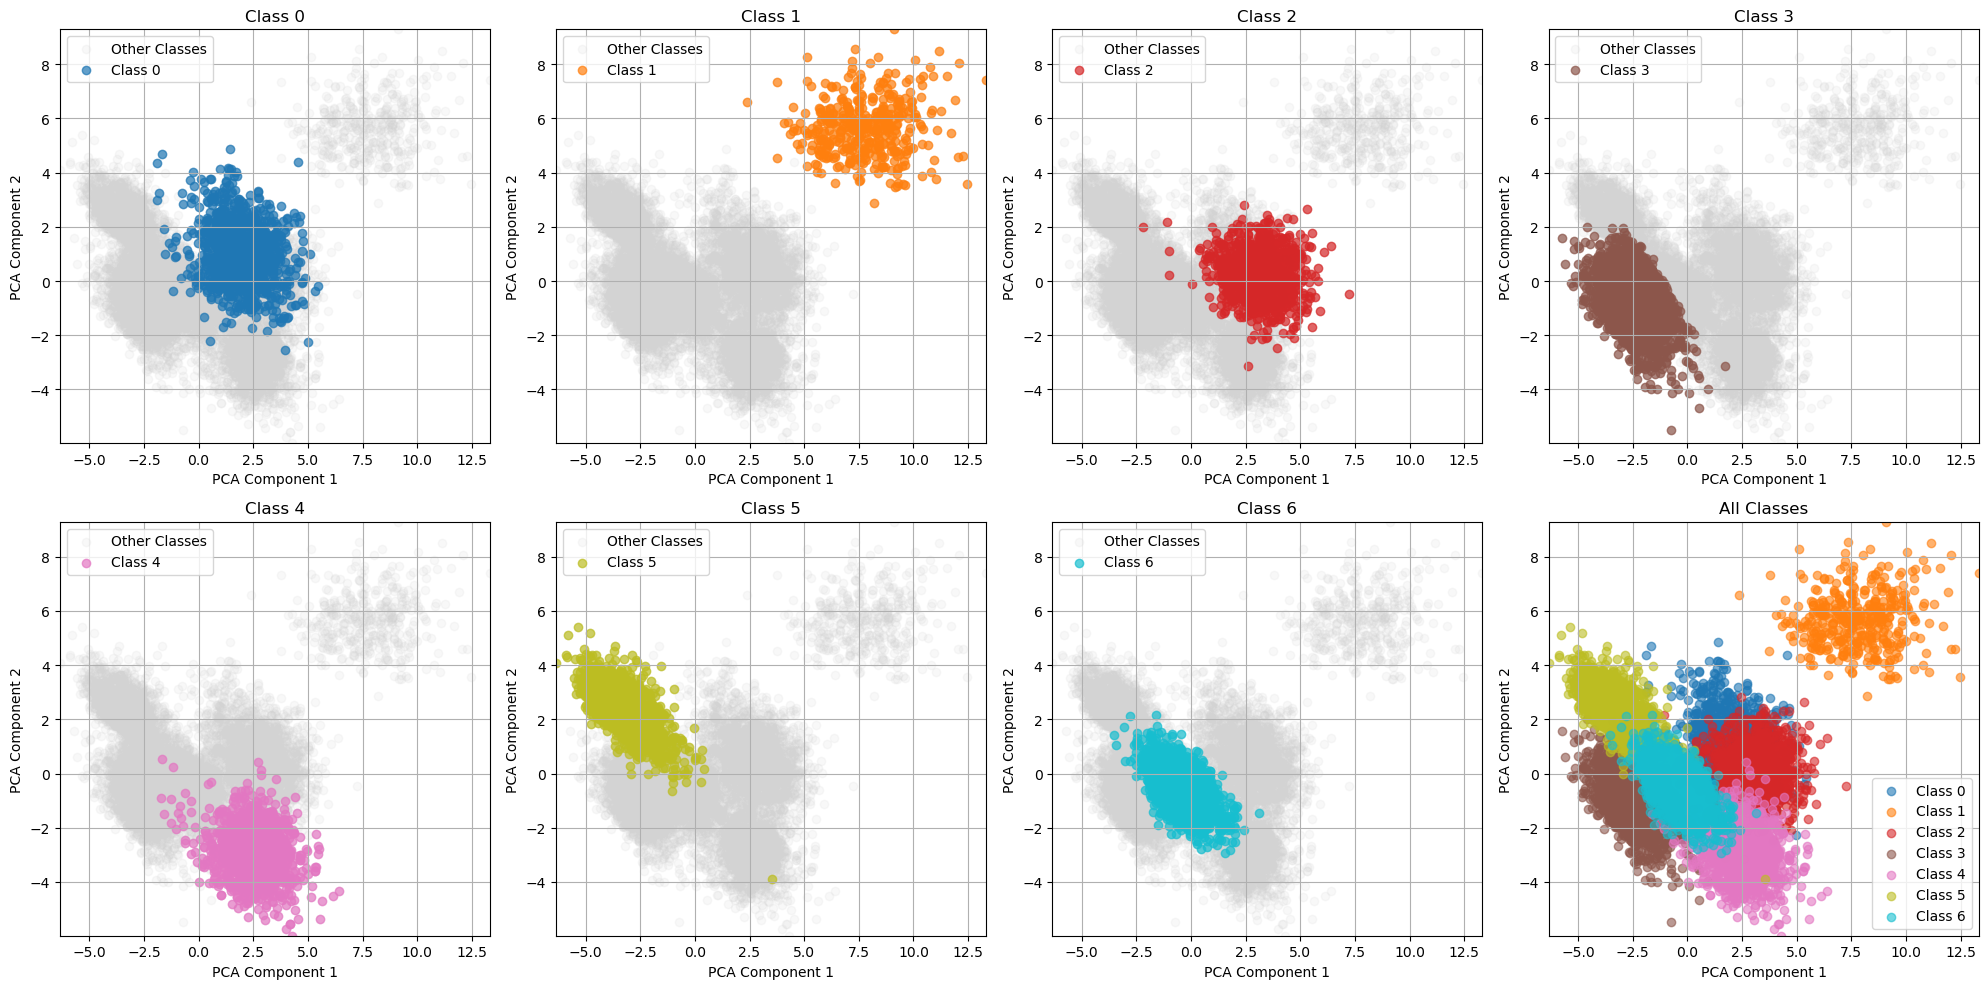

3D PCA...


C:\Users\14198\AppData\Local\Temp\ipykernel_22808\963221847.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(y_numeric)))


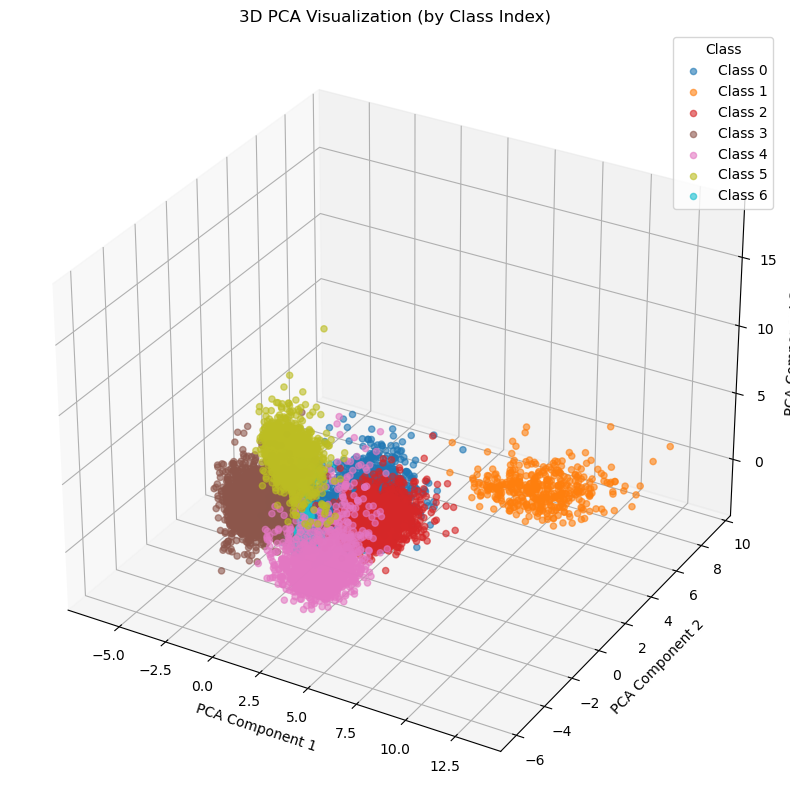

In [ ]:
# Part two: Data Visualization
# Apply PCA for dimensionality reduction and visualize the 2D, 3D results
from sklearn.decomposition import PCA

def visualize_2d_pca(X, y_numeric, save_path='visual_pict'):
    print("2D PCA...")
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X)

    os.makedirs(save_path, exist_ok=True)

    unique_classes = np.unique(y_numeric)
    n_classes = len(unique_classes)

    # Prepare 2x4 subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    cmap = plt.cm.get_cmap('tab10', n_classes)

    # Find global axis limits for consistent scaling
    x_min, x_max = X_pca_2d[:, 0].min(), X_pca_2d[:, 0].max()
    y_min, y_max = X_pca_2d[:, 1].min(), X_pca_2d[:, 1].max()

    # Plot each class separately, but show all points in gray for context
    for i, class_label in enumerate(unique_classes):
        row, col = divmod(i, 4)
        ax = axes[row, col]
        # Plot all points in light gray
        ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.15, color='lightgray', label='Other Classes')
        # Highlight current class
        idx = y_numeric == class_label
        ax.scatter(X_pca_2d[idx, 0], X_pca_2d[idx, 1],
                   alpha=0.7, color=cmap(i), label=f'Class {class_label}')
        ax.set_title(f'Class {class_label}')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.grid(True)

    # Plot the whole graph in (2,4)
    ax = axes[1, 3]
    for i, class_label in enumerate(unique_classes):
        idx = y_numeric == class_label
        ax.scatter(X_pca_2d[idx, 0], X_pca_2d[idx, 1],
                   alpha=0.6, color=cmap(i), label=f'Class {class_label}')
    ax.set_title('All Classes')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)

    # Hide unused subplot if n_classes < 7
    for j in range(n_classes, 7):
        row, col = divmod(j, 4)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_path}/pca_label_2d_all.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_3d_pca(X, y_numeric, save_path='visual_pict'):
    print("3D PCA...")
    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(X)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    cmap = plt.cm.get_cmap('tab10', len(np.unique(y_numeric)))

    for i in np.unique(y_numeric):
        idx = y_numeric == i
        ax.scatter(X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2],
                   alpha=0.6, c=[cmap(i)], label=f'Class {i}')

    ax.set_title('3D PCA Visualization (by Class Index)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend(title='Class', loc='best')
    plt.savefig(f'{save_path}/pca_label_3d.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_2d_pca(X_train_scaled, y_train)
visualize_3d_pca(X_train_scaled, y_train)


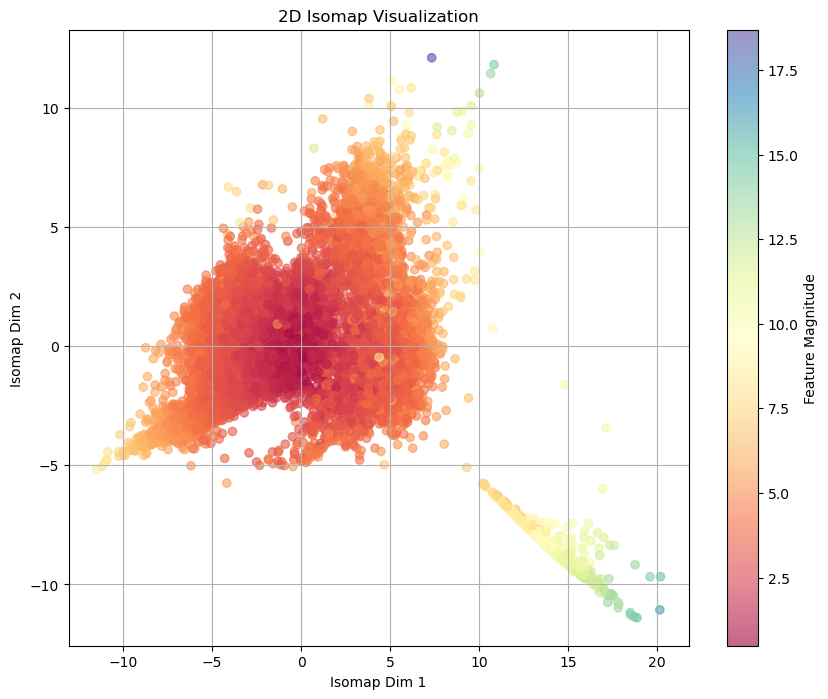

In [11]:
# Part two: Data Visualization
# Apply isomap for dimensionality reduction and visualize the 2D results
from sklearn.manifold import Isomap

def visualize_isomap_2d(X):
    isomap = Isomap(n_components=2)
    X_iso = isomap.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_iso[:, 0], X_iso[:, 1], alpha=0.6,
                c=np.linalg.norm(X, axis=1), cmap='Spectral')
    plt.colorbar(label='Feature Magnitude')
    plt.title('2D Isomap Visualization')
    plt.xlabel('Isomap Dim 1')
    plt.ylabel('Isomap Dim 2')
    plt.grid(True)
    # plt.savefig(f'{save_path}/isomap_2d.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_isomap_2d(X_train_scaled)

In [12]:
# Part three: Clustering
# Construct a relatively complete clustering evaluation function
# to evaluate the clustering performance from external and internal metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, v_measure_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from collections import Counter

def purity_score(y_true, y_pred):
    cluster_labels = np.unique(y_pred)
    total_correct = 0
    for cluster in cluster_labels:
        idx = np.where(y_pred == cluster)
        true_labels, counts = np.unique(y_true[idx], return_counts=True)
        total_correct += np.max(counts)
    return total_correct / len(y_true)

from scipy.spatial.distance import cdist
import numpy as np

def dunn_index(X, labels):
    clusters = np.unique(labels)
    cluster_data = [X[labels == c] for c in clusters]
    
    # the maximum distance within each cluster
    intra_dists = [np.max(cdist(c, c)) for c in cluster_data if len(c) > 1]
    max_intra = max(intra_dists) if intra_dists else 1e-10
    
    # the minimum distance between clusters
    min_inter = np.inf
    for i in range(len(cluster_data)):
        for j in range(i + 1, len(cluster_data)):
            dist = np.min(cdist(cluster_data[i], cluster_data[j]))
            min_inter = min(min_inter, dist)
    
    return min_inter / max_intra


def evaluate_clustering(X, y_true, y_pred):
    print(" external metric:")
    print(f"  ARI  (Adjusted Rand Index):     {adjusted_rand_score(y_true, y_pred):.4f}")
    print(f"  NMI  (Normalized Mutual Info):  {normalized_mutual_info_score(y_true, y_pred):.4f}")
    print(f"  FMI  (Fowlkes-Mallows Index):   {fowlkes_mallows_score(y_true, y_pred):.4f}")
    print(f"  V-measure:                     {v_measure_score(y_true, y_pred):.4f}")
    print(f"  Purity:                        {purity_score(y_true, y_pred):.4f}")
    
    print("\n internal metric")
    print(f"  Silhouette Score:               {silhouette_score(X, y_pred):.4f}")
    print(f"  Calinski-Harabasz Index:        {calinski_harabasz_score(X, y_pred):.2f}")
    print(f"  Davies-Bouldin Index:           {davies_bouldin_score(X, y_pred):.4f}")
    print(f"  Dunn Index:                     {dunn_index(X, y_pred):.4f}")


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

def visualize_clusters(X, cluster_labels, title="Cluster Visualization"):
    # 将簇标签映射为连续整数（0, 1, ..., n-1）
    cluster_labels = LabelEncoder().fit_transform(cluster_labels)

    # PCA降维
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # 可视化
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap='tab10', s=30)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [27]:
# Part three: Clustering
# Prototype-based Clustering
# Apply KMeans clustering and demonstrate the results
from sklearn.cluster import KMeans

def apply_kmeans(X, n_clusters=7, random_state=42):
    print("应用 K-Means 聚类...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    cluster_labels = kmeans.fit_predict(X)
    return cluster_labels

kmeans_labels = apply_kmeans(X_train_scaled, n_clusters=7)



print(" K-Means 聚类评估结果：")
evaluate_clustering(X_train_scaled, y_train, kmeans_labels)

应用 K-Means 聚类...
 K-Means 聚类评估结果：
 external metric:
  ARI  (Adjusted Rand Index):     0.6642
  NMI  (Normalized Mutual Info):  0.7103
  FMI  (Fowlkes-Mallows Index):   0.7242
  V-measure:                     0.7103
  Purity:                        0.7961

 internal metric
  Silhouette Score:               0.3094
  Calinski-Harabasz Index:        6238.77
  Davies-Bouldin Index:           1.0983
  Dunn Index:                     0.0080


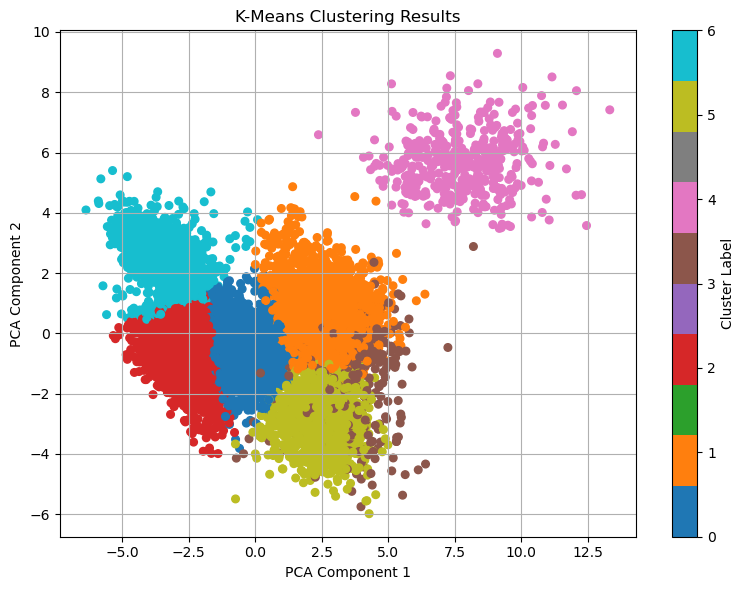

In [28]:
# Part three: Clustering
# Visualize the K-Means clustering results
visualize_clusters(X_train_scaled, kmeans_labels, title="K-Means Clustering Results")

In [22]:
# Part three: Clustering
# Prototype-based Clustering
# Apply K-Medoids clustering and demonstrate the results
from sklearn_extra.cluster import KMedoids  # 需要安装scikit-learn-extra
import numpy as np

def apply_kmedoids_clustering(X, n_clusters=10, metric='euclidean'):
    print("应用 K-Medoids 聚类...")
    kmedoids = KMedoids(n_clusters=n_clusters, metric=metric, random_state=42)
    cluster_labels = kmedoids.fit_predict(X)
    return cluster_labels


print(" K-Medoids 聚类评估结果：")
kmedoids_labels = apply_kmedoids_clustering(X_train_scaled, n_clusters=7)
evaluate_clustering(X_train_scaled, y_train, kmedoids_labels)

 K-Medoids 聚类评估结果：
应用 K-Medoids 聚类...
 external metric:
  ARI  (Adjusted Rand Index):     0.6363
  NMI  (Normalized Mutual Info):  0.6853
  FMI  (Fowlkes-Mallows Index):   0.6984
  V-measure:                     0.6853
  Purity:                        0.8136

 internal metric
  Silhouette Score:               0.2694
  Calinski-Harabasz Index:        4266.29
  Davies-Bouldin Index:           1.3033
  Dunn Index:                     0.0071


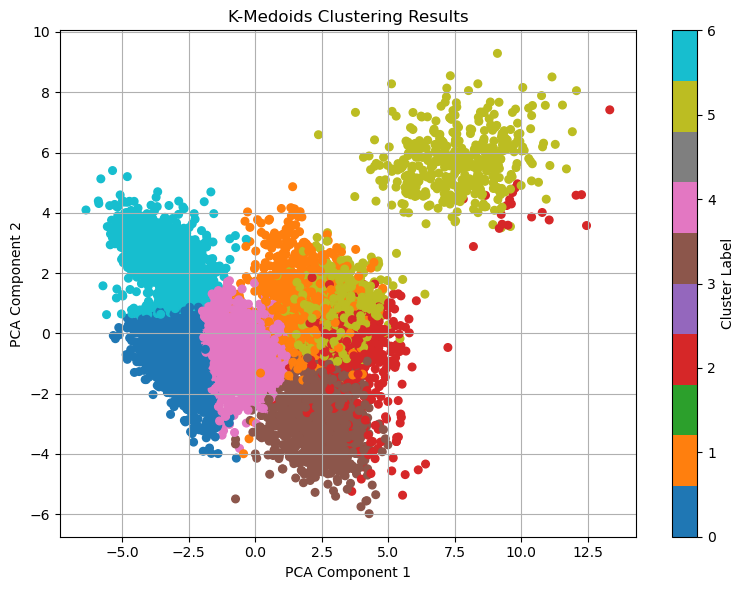

In [23]:
# Part three: Clustering
# visual the clustering results
visualize_clusters(X_train_scaled, kmedoids_labels, title="K-Medoids Clustering Results")

In [ ]:
# Part three: Clustering
# Hierarchical Clustering
# Apply Agglomerative clustering and demonstrate the results

from sklearn.cluster import AgglomerativeClustering

def apply_hierarchical_clustering(X, n_clusters=7):
    print("应用 Hierarchical Clustering...")
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = hierarchical.fit_predict(X)
    return cluster_labels


print(" 层次聚类评估结果：")
hierarchical_labels = apply_hierarchical_clustering(X_train_scaled, n_clusters=7)
evaluate_clustering(X_train_scaled, y_train, hierarchical_labels)


 层次聚类评估结果：
应用 Hierarchical Clustering...
 external metric:
  ARI  (Adjusted Rand Index):     0.6387
  NMI  (Normalized Mutual Info):  0.7187
  FMI  (Fowlkes-Mallows Index):   0.7063
  V-measure:                     0.7187
  Purity:                        0.7863

 internal metric
  Silhouette Score:               0.2788
  Calinski-Harabasz Index:        5517.31
  Davies-Bouldin Index:           1.1371
  Dunn Index:                     0.0140


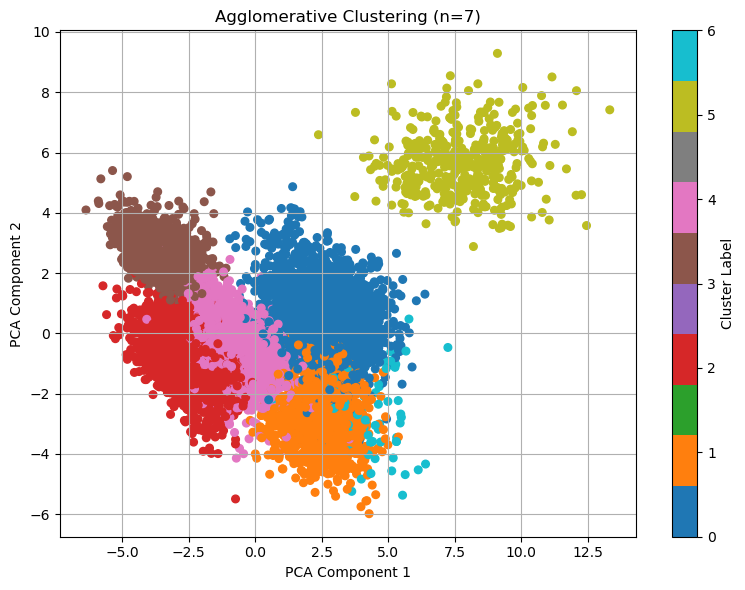

In [ ]:
# Part three: Clustering
# Hierarchical Clustering   
# Visualize the Agglomerative clustering results 

custom_colors = ['blue', 'green', 'purple', 'yellow', 'yellow', 'orange', 'red']
visualize_clusters(X_train_scaled, hierarchical_labels, title="Agglomerative Clustering (n=7)")


In [10]:
# Part three: Clustering
# Hierarchical Clustering
# Apply divisive clustering and demonstrate the results
from sklearn.cluster import KMeans
import numpy as np

def apply_divisive_clustering(X, n_clusters=7):
    print("Apply Divisive Clustering ...")

    clusters = {0: X}
    labels = np.zeros(len(X), dtype=int)
    current_label = 1

    while len(clusters) < n_clusters:
        largest_cluster = max(clusters.items(), key=lambda x: len(x[1]))[0]
        data_to_split = clusters.pop(largest_cluster)

        kmeans = KMeans(n_clusters=2, random_state=0).fit(data_to_split)
        split_labels = kmeans.labels_

        original_indices = np.where(labels == largest_cluster)[0]

        for i in [0, 1]:
            new_cluster_data = data_to_split[split_labels == i]
            new_cluster_indices = original_indices[split_labels == i]
            clusters[current_label] = new_cluster_data
            labels[new_cluster_indices] = current_label
            current_label += 1

    return labels



print(" Divisive Cluster  ")
divisive_labels = apply_divisive_clustering(X_train_scaled, n_clusters=7)
evaluate_clustering(X_train_scaled, y_train, divisive_labels)


 Divisive Cluster  
Apply Divisive Clustering ...


d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(
d:\

 external metric:
  ARI  (Adjusted Rand Index):     0.5852
  NMI  (Normalized Mutual Info):  0.6665
  FMI  (Fowlkes-Mallows Index):   0.6557
  V-measure:                     0.6665
  Purity:                        0.7754

 internal metric
  Silhouette Score:               0.2587
  Calinski-Harabasz Index:        5320.99
  Davies-Bouldin Index:           1.2628
  Dunn Index:                     0.0088


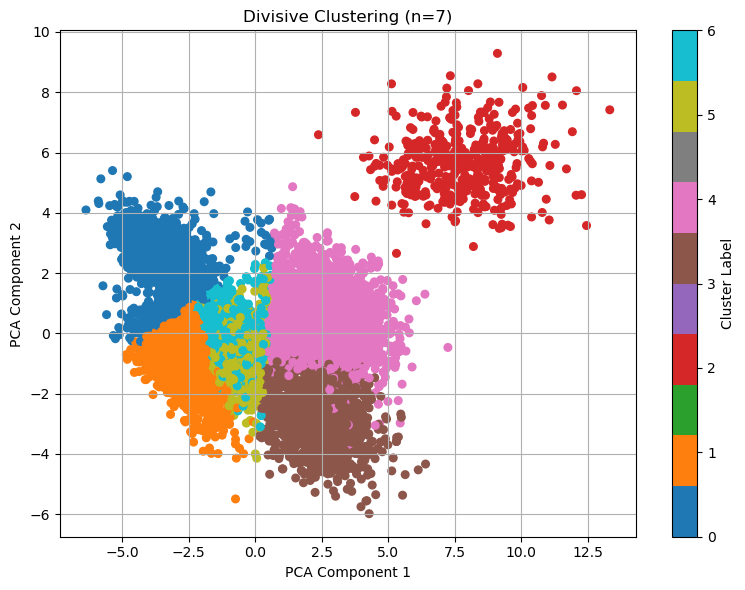

In [ ]:
# Part three: Clustering
# Hierarchical Clustering
# Visual divisive clustering 


custom_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'yellow'] 
visualize_clusters(X_train_scaled, divisive_labels, title="Divisive Clustering (n=7)")

In [ ]:
# Part three: Clustering
# Density-based Clustering
# Apply DBSCAN clustering and demonstrate the results

from sklearn.cluster import DBSCAN

def apply_dbscan_clustering(X, eps=0.5, min_samples=85):
    print("应用 DBSCAN Clustering...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)
    return cluster_labels




print(" DBSCAN 聚类评估结果：")
dbscan_labels = apply_dbscan_clustering(X_train_scaled, eps=0.3, min_samples=5)
evaluate_clustering(X_train_scaled, y_train, dbscan_labels)


 DBSCAN 聚类评估结果：
应用 DBSCAN Clustering...
 external metric:
  ARI  (Adjusted Rand Index):     0.0017
  NMI  (Normalized Mutual Info):  0.1368
  FMI  (Fowlkes-Mallows Index):   0.3776
  V-measure:                     0.1368
  Purity:                        0.3261

 internal metric
  Silhouette Score:               -0.5162
  Calinski-Harabasz Index:        14.25
  Davies-Bouldin Index:           1.5273
  Dunn Index:                     0.0045


In [ ]:
# Part three: Clustering
# Density-based Clustering
# Apply HDBSCAN clustering and demonstrate the results
import hdbscan

def apply_hdbscan_clustering(X, min_cluster_size=5):
    print("应用 HDBSCAN Clustering...")
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    cluster_labels = hdb.fit_predict(X)
    return cluster_labels


print(" HDBSCAN 聚类评估结果：")
hdbscan_labels = apply_hdbscan_clustering(X_train_scaled, min_cluster_size=5)
evaluate_clustering(X_train_scaled, y_train, hdbscan_labels)


 HDBSCAN 聚类评估结果：
应用 HDBSCAN Clustering...
 external metric:
  ARI  (Adjusted Rand Index):     0.0385
  NMI  (Normalized Mutual Info):  0.1386
  FMI  (Fowlkes-Mallows Index):   0.4172
  V-measure:                     0.1386
  Purity:                        0.3043

 internal metric
  Silhouette Score:               0.0599
  Calinski-Harabasz Index:        819.14
  Davies-Bouldin Index:           1.5074
  Dunn Index:                     0.0177


In [ ]:
# Part three: Clustering
# Density-based Clustering
# Apply OPTICS clustering and demonstrate the results
from sklearn.cluster import OPTICS

def apply_optics_clustering(X, min_samples=5, xi=0.03, min_cluster_size=0.05):
    print("应用 OPTICS Clustering...")
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    cluster_labels = optics.fit_predict(X)
    return cluster_labels


print("OPTICS 聚类评估结果：")
optics_labels = apply_optics_clustering(X_train_scaled, min_samples=5)
evaluate_clustering(X_train_scaled, y_train, optics_labels)


OPTICS 聚类评估结果：
应用 OPTICS Clustering...
 external metric:
  ARI  (Adjusted Rand Index):     0.0005
  NMI  (Normalized Mutual Info):  0.0016
  FMI  (Fowlkes-Mallows Index):   0.4162
  V-measure:                     0.0016
  Purity:                        0.2646

 internal metric
  Silhouette Score:               0.5349
  Calinski-Harabasz Index:        96.01
  Davies-Bouldin Index:           1.4662
  Dunn Index:                     0.0511


In [ ]:
# Part three: Clustering
# Model-based Clustering - Gaussian Mixture Model (GMM)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import numpy as np

# GMM
def apply_gmm_clustering(X, n_components=3, covariance_type='full'):
    print("应用 GMM 聚类...")
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm_labels = gmm.fit_predict(X)
    return gmm_labels


print("GMM 聚类评估结果：")
gmm_labels = apply_gmm_clustering(X_train_scaled, n_components=3)
evaluate_clustering(X_train_scaled, y_train, gmm_labels) 


GMM 聚类评估结果：
应用 GMM 聚类...
 external metric:
  ARI  (Adjusted Rand Index):     0.3110
  NMI  (Normalized Mutual Info):  0.5061
  FMI  (Fowlkes-Mallows Index):   0.5502
  V-measure:                     0.5061
  Purity:                        0.4380

 internal metric
  Silhouette Score:               0.4039
  Calinski-Harabasz Index:        6879.97
  Davies-Bouldin Index:           0.9084
  Dunn Index:                     0.0091


In [20]:
# Part three: Clustering
# Model-based Clustering - Hidden Markov Model (HMM)
from hmmlearn import hmm
import numpy as np

def apply_hmm_clustering(X, n_components=3):
    print("应用 HMM 聚类...")
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")
    # 假设 X 为 2D 数据，适合用来表示多个时间步长的序列
    model.fit(X)  # 训练模型
    hmm_labels = model.predict(X)  # 获取预测标签
    return hmm_labels

# 训练 HMM 模型
print("HMM 聚类评估结果：")
hmm_labels = apply_hmm_clustering(X_train_scaled, n_components=3)
evaluate_clustering(X_train_scaled, y_train, hmm_labels)  


HMM 聚类评估结果：
应用 HMM 聚类...
 external metric:
  ARI  (Adjusted Rand Index):     0.3133
  NMI  (Normalized Mutual Info):  0.5096
  FMI  (Fowlkes-Mallows Index):   0.5528
  V-measure:                     0.5096
  Purity:                        0.4383

 internal metric
  Silhouette Score:               0.4052
  Calinski-Harabasz Index:        6873.90
  Davies-Bouldin Index:           0.9094
  Dunn Index:                     0.0091


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import numpy as np


class AutoEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re, z

def apply_dec_clustering(X, n_clusters=7, epochs=30):
    print("应用 DEC (Deep Embedded Clustering)...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    model = AutoEncoder(input_dim=X.shape[1], latent_dim=n_clusters).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

# train the AutoEncoder
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_re, _ = model(X_tensor)
        loss = loss_fn(x_re, X_tensor)
        loss.backward()
        optimizer.step()

# Extract the latent representation
    with torch.no_grad():
        _, embedded = model(X_tensor)
        embedded_np = embedded.cpu().numpy()

# Apply KMeans clustering as a post-processing step
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    cluster_labels = kmeans.fit_predict(embedded_np)

    return cluster_labels



print("DEC 聚类评估结果：")
dec_labels = apply_dec_clustering(X_train_scaled, n_clusters=7, epochs=50)

evaluate_clustering(X_train_scaled, y_train, dec_labels)


DEC 聚类评估结果：
应用 DEC (Deep Embedded Clustering)...
 external metric:
  ARI  (Adjusted Rand Index):     0.5986
  NMI  (Normalized Mutual Info):  0.6688
  FMI  (Fowlkes-Mallows Index):   0.6681
  V-measure:                     0.6688
  Purity:                        0.7994

 internal metric
  Silhouette Score:               0.2505
  Calinski-Harabasz Index:        5431.18
  Davies-Bouldin Index:           1.4345
  Dunn Index:                     0.0080


In [10]:
# Part three: Clustering
# Model-based Clustering - Deep Embedded Clustering (DEC)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import ParameterGrid
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re, z
    
def train_dec(X, y_true, params):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # 初始化模型
    model = AutoEncoder(
        input_dim=X.shape[1],
        hidden_dim=params['hidden_dim'],
        latent_dim=params['latent_dim']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.MSELoss()

    # 训练自编码器
    model.train()
    for epoch in range(params['epochs']):
        optimizer.zero_grad()
        x_re, _ = model(X_tensor)
        loss = loss_fn(x_re, X_tensor)
        loss.backward()
        optimizer.step()

    # 提取潜在特征并聚类
    with torch.no_grad():
        _, embedded = model(X_tensor)
        embedded_np = embedded.cpu().numpy()
    
    kmeans = KMeans(n_clusters=params['n_clusters'], n_init=20)
    cluster_labels = kmeans.fit_predict(embedded_np)
    
    # 计算ARI
    ari = adjusted_rand_score(y_true, cluster_labels)
    return ari

# Grid Search for Hyperparameters
param_grid = {
    'latent_dim': [10, 20, 30],      # 潜在空间维度
    'hidden_dim': [256, 512],   # 隐藏层维度
    'n_clusters': [7],        # cluster数量
    'lr': [1e-4, 1e-3, 1e-2],        # 学习率
    'epochs': [30, 50]          # 训练轮数
}

# 网格搜索
best_ari = -1
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    try:
        ari = train_dec(X_train_scaled, y_train, params)
        print(f"ARI: {ari:.4f}")
        if ari > best_ari:
            best_ari = ari
            best_params = params
    except Exception as e:
        print(f"Failed with {params}: {str(e)}")

print("\n Best Parameters:")
print(best_params)
print(f"Best ARI: {best_ari:.4f}")

Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 10, 'lr': 0.0001, 'n_clusters': 7}
ARI: 0.6375
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 10, 'lr': 0.001, 'n_clusters': 7}
ARI: 0.4572
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 10, 'lr': 0.01, 'n_clusters': 7}
ARI: 0.6121
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 20, 'lr': 0.0001, 'n_clusters': 7}
ARI: 0.4768
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 20, 'lr': 0.001, 'n_clusters': 7}
ARI: 0.5291
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 20, 'lr': 0.01, 'n_clusters': 7}
ARI: 0.4998
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 30, 'lr': 0.0001, 'n_clusters': 7}
ARI: 0.6173
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 30, 'lr': 0.001, 'n_clusters': 7}
ARI: 0.5289
Testing params: {'epochs': 30, 'hidden_dim': 256, 'latent_dim': 30, 'lr': 0.01, 'n_clusters': 7}
ARI: 0.4848
Testing pa

In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, input_dim=784, feature_dim=256, hidden_dim=512):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),  # 添加inplace节省内存
            nn.Dropout(p=0.1),      # 添加dropout防止过拟合
            nn.Linear(hidden_dim, feature_dim)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.feature_extractor(x)


def deep_cluster_fit(X, n_clusters=7, max_epochs=50, learning_rate=1e-3, verbose=True):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print(f" 使用设备: {device}")
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    model = SimpleMLP(input_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

    model.train()
    for epoch in range(1, max_epochs + 1):
        with torch.no_grad():
            features = model(X_tensor).cpu().numpy()
        # KMeans 聚类
        kmeans = KMeans(n_clusters=n_clusters, n_init=15)
        cluster_labels = kmeans.fit_predict(features)
        target = torch.tensor(cluster_labels, dtype=torch.long).to(device)
        outputs = model(X_tensor)
        loss = nn.CrossEntropyLoss()(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch}/{max_epochs} - Loss: {loss.item():.4f}")

    with torch.no_grad():
        final_features = model(X_tensor).cpu().numpy()
        final_kmeans = KMeans(n_clusters=n_clusters, n_init=20)
        final_labels = final_kmeans.fit_predict(final_features)
    
    return final_labels


# evaluation
print("\nDeepCluster 聚类评估:")
cluster_results = deep_cluster_fit(
    X_train_scaled,
    n_clusters=7,
    max_epochs=50,
    learning_rate=0.001,
    verbose=True
)

print("\n评估聚类效果:")

evaluate_clustering(X_train_scaled, y_train, cluster_results)


DeepCluster 聚类评估:
 使用设备: cpu
Epoch 10/50 - Loss: 4.7631
Epoch 20/50 - Loss: 3.6623
Epoch 30/50 - Loss: 3.1197
Epoch 40/50 - Loss: 2.6573
Epoch 50/50 - Loss: 2.2911

评估聚类效果:
 external metric:
  ARI  (Adjusted Rand Index):     0.2382
  NMI  (Normalized Mutual Info):  0.3600
  FMI  (Fowlkes-Mallows Index):   0.3734
  V-measure:                     0.3600
  Purity:                        0.5310

 internal metric
  Silhouette Score:               0.0200
  Calinski-Harabasz Index:        1310.22
  Davies-Bouldin Index:           7.5836
  Dunn Index:                     0.0000


In [36]:
# Part four: Prediction: Training and Testing
# Linear-based Classifier
# Apply Logistic Regression and demonstrate the results
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(
    penalty='none',            
    solver='saga',           
    max_iter=1000,
    random_state=42
)

# 拟合模型
log_reg.fit(X_train_scaled, y_train)

# 预测
y_pred_log = log_reg.predict(X_test_scaled)

# 评估
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))


d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logistic Regression Accuracy: 0.9251

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       261
           1       1.00      1.00      1.00       117
           2       0.93      0.94      0.94       317
           3       0.92      0.90      0.91       671
           4       0.97      0.96      0.96       408
           5       0.97      0.94      0.95       413
           6       0.85      0.90      0.87       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [37]:
# Part four: Prediction: Training and Testing
# Linear-based Classifier
# Logistic Regression with Ridge Regularization (L2)
log_reg_ridge = LogisticRegression(
    penalty='l2',              
    C=1.0,                     # 正则强度的倒数，C 越小正则越强
    solver='saga',           
    max_iter=1000,
    random_state=42
)


log_reg_ridge.fit(X_train_scaled, y_train)


y_pred_ridge = log_reg_ridge.predict(X_test_scaled)

print(f"Logistic Regression (Ridge) Accuracy: {accuracy_score(y_test, y_pred_ridge):.4f}")
print("\nLogistic Regression (Ridge) Classification Report:")
print(classification_report(y_test, y_pred_ridge))


Logistic Regression (Ridge) Accuracy: 0.9266

Logistic Regression (Ridge) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       261
           1       1.00      1.00      1.00       117
           2       0.95      0.94      0.94       317
           3       0.92      0.90      0.91       671
           4       0.97      0.96      0.97       408
           5       0.97      0.94      0.95       413
           6       0.85      0.90      0.87       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Part four: Prediction: Training and Testing
# Tree-based Classifier
# Apply Decision Tree Classifier and demonstrate the results
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt




tree = DecisionTreeClassifier(
    criterion='entropy',       
    max_depth= 8,   
    min_samples_split=10,  # 最小分割样本数
    min_samples_leaf=2,     
    random_state=42
)

# X with noise perform best
# tree.fit(X_train_scaled, y_train)
tree.fit(X_train_noisy, y_train)
# tree.fit(X_train_no_outliers, y_train_no_outliers)



y_pred = tree.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 分类报告（包括精确率、召回率、F1等）
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9155

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       261
           1       1.00      1.00      1.00       117
           2       0.92      0.91      0.92       317
           3       0.88      0.93      0.90       671
           4       0.98      0.92      0.95       408
           5       0.95      0.92      0.94       413
           6       0.89      0.87      0.88       536

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 定义超参数搜索空间
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 6, 7, 8, 9, 10, 20, 30],
    'min_samples_split': [1, 2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 初始化模型
dtree = DecisionTreeClassifier(random_state=42)

# 网格搜索 + 5折交叉验证
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "d:\anaconda\envs\cnn-env\lib\site-packages\sklearn\base.py", li

Best parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
# Part four: Prediction: Training and Testing
# Tree-based Classifier
# Apply Extra Trees Classifier and demonstrate the results
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 初始化 ExtraTreesClassifier
extra_tree = ExtraTreesClassifier(
    n_estimators=100,          # number of trees
    criterion='entropy',       # the function to measure the quality of a split
    max_depth=8,             
    min_samples_split=10,      # the minimum number of samples required to split an internal node
    min_samples_leaf=2,        # the minimum number of samples required to be at a leaf node
    random_state=42
)

extra_tree.fit(X_train_scaled, y_train)
#extra_tree.fit(X_train_noisy, y_train)


y_pred_extra = extra_tree.predict(X_test_scaled)


print(f"Extra Trees Accuracy: {accuracy_score(y_test, y_pred_extra):.4f}")

print("\nExtra Trees Classification Report:")
print(classification_report(y_test, y_pred_extra))


Extra Trees Accuracy: 0.9064

Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       261
           1       1.00      1.00      1.00       117
           2       0.86      0.91      0.89       317
           3       0.90      0.91      0.91       671
           4       0.97      0.95      0.96       408
           5       0.95      0.94      0.94       413
           6       0.85      0.87      0.86       536

    accuracy                           0.91      2723
   macro avg       0.92      0.91      0.91      2723
weighted avg       0.91      0.91      0.91      2723



In [38]:
# Part four: Prediction: Training and Testing
# SVM Classifier
# Apply Support Vector Machine (SVM) and demonstrate the results
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_clf = SVC(
    kernel='linear',         # 常用的核函数之一（也可以试 'linear'）
    C=1.0,                # 正则化参数
    gamma='scale',        # 核函数系数（'scale' 是推荐默认）
    random_state=42
)


svm_clf.fit(X_train_scaled, y_train)


y_pred_svm = svm_clf.predict(X_test_scaled)


print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9284

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       261
           1       1.00      1.00      1.00       117
           2       0.94      0.94      0.94       317
           3       0.91      0.91      0.91       671
           4       0.97      0.97      0.97       408
           5       0.97      0.94      0.96       413
           6       0.87      0.89      0.88       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [6]:
# Part four: Prediction: Training and Testing
# SVM Classifier
# Apply kernal Support Vector Machine (SVM) and demonstrate the results
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_clf = SVC(
    kernel='rbf',         
    C=1.0,               
    gamma='scale',        
    random_state=42
)

svm_clf.fit(X_train_scaled, y_train)


y_pred_svm = svm_clf.predict(X_test_scaled)

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9339

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.94       317
           3       0.91      0.93      0.92       671
           4       0.98      0.96      0.97       408
           5       0.97      0.95      0.96       413
           6       0.88      0.90      0.89       536

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [39]:
# Part four: Prediction: Training and Testing
# Apply K-Nearest Neighbors (KNN) and demonstrate the results
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_clf = KNeighborsClassifier(
    n_neighbors=5,        
    weights='uniform',    # or 'distance'
    metric='minkowski',   
)


knn_clf.fit(X_train_scaled, y_train)


y_pred_knn = knn_clf.predict(X_test_scaled)

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.9232

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       261
           1       1.00      1.00      1.00       117
           2       0.92      0.96      0.94       317
           3       0.89      0.91      0.90       671
           4       0.97      0.95      0.96       408
           5       0.97      0.95      0.96       413
           6       0.86      0.87      0.86       536

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.94      2723
weighted avg       0.92      0.92      0.92      2723



In [16]:
# Part four: Prediction: Training and Testing
# Neural Network Classifier - Multilayer Perceptron (MLP)
# Comment: Performance is not as good as expected, not outstanding at all
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# construct the multi-layer perceptron model
# alpha: regularization parameter, solver: optimization algorithm, tol: stop condition
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha = 1e-4,
                        solver='lbfgs', tol=1e-6, random_state=42)

mlp_clf.fit(X_train_scaled, y_train)

y_train_pred = mlp_clf.predict(X_train_scaled)
y_test_pred = mlp_clf.predict(X_test_scaled)

accuracy_train = accuracy_score(y_train_pred, y_train)
accuracy_test = accuracy_score(y_test_pred, y_test)

print(f"Training accuracy: {accuracy_train:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\n")
print(f"Testing accuracy: {accuracy_test:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred))

Training accuracy: 0.9413

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1061
           1       1.00      1.00      1.00       405
           2       0.96      0.96      0.96      1313
           3       0.93      0.94      0.93      2875
           4       0.97      0.96      0.97      1520
           5       0.96      0.96      0.96      1614
           6       0.89      0.89      0.89      2100

    accuracy                           0.94     10888
   macro avg       0.95      0.95      0.95     10888
weighted avg       0.94      0.94      0.94     10888



Testing accuracy: 0.9302

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.94       317
           3       0.91      0.92      0.92       671
           4       0.97

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# Improvement: Feature selection: Filter method: SelectKBest, score_func=f_classif / mutual_info_classif
# f_classif is to justify some features' mean difference are obvious or not between different classes.
# f_mutual_info_classif is to justify the features' mutual information with the target label.
# We split the training data into train/validation set for k selection, and then use the best k=12 to fit on the full training set. 

# Comment: Performance is even lower than the original one that do not select the features.
# The reason could be that this feature selection method might drop features that are only useful together with others.

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split training data into train/validation for k selection
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

k_accuracy_1 = []
k_accuracy_2 = []
for k in range(5, 17):
    selector1 = SelectKBest(score_func=f_classif, k=k)
    X_new_train_sub = selector1.fit_transform(X_train_sub, y_train_sub)
    X_new_val = selector1.transform(X_val)

    selector2 = SelectKBest(score_func=mutual_info_classif, k=k)
    X_new_train_sub_2 = selector2.fit_transform(X_train_sub, y_train_sub)
    X_new_val_2 = selector2.transform(X_val)

    mlp_clf1 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                             solver='lbfgs', tol=1e-6, random_state=42)
    mlp_clf1.fit(X_new_train_sub, y_train_sub)
    y_val_pred = mlp_clf1.predict(X_new_val)
    accuracy_val_1 = accuracy_score(y_val, y_val_pred)
    k_accuracy_1.append(accuracy_val_1)

    mlp_clf2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                             solver='lbfgs', tol=1e-6, random_state=42)
    mlp_clf2.fit(X_new_train_sub_2, y_train_sub)
    y_val_pred_2 = mlp_clf2.predict(X_new_val_2)
    accuracy_val_2 = accuracy_score(y_val, y_val_pred_2)
    k_accuracy_2.append(accuracy_val_2)

# Get best k for both methods
best_k_1 = k_accuracy_1.index(max(k_accuracy_1)) + 1
best_k_2 = k_accuracy_2.index(max(k_accuracy_2)) + 1

print(f"Best k for f_classif: {best_k_1}")
print(f"Best k for mutual_info_classif: {best_k_2}")

# Use best k to fit on full training set and evaluate on test set
selector1 = SelectKBest(score_func=f_classif, k=best_k_1)
X_new_train_scaled = selector1.fit_transform(X_train_scaled, y_train)
X_new_test_scaled = selector1.transform(X_test_scaled)

mlp_clf1 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                         solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf1.fit(X_new_train_scaled, y_train)
y_train_pred = mlp_clf1.predict(X_new_train_scaled)
y_test_pred = mlp_clf1.predict(X_new_test_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {accuracy_train:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\n")
print(f"Testing accuracy: {accuracy_test:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred))


selector2 = SelectKBest(score_func=mutual_info_classif, k=best_k_2)
X_new_train_scaled_2 = selector2.fit_transform(X_train_scaled, y_train)
X_new_test_scaled_2 = selector2.transform(X_test_scaled)

mlp_clf2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                            solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf2.fit(X_new_train_scaled_2, y_train)

y_train_pred_2 = mlp_clf2.predict(X_new_train_scaled_2)
y_test_pred_2 = mlp_clf2.predict(X_new_test_scaled_2)

accuracy_train_2 = accuracy_score(y_train, y_train_pred_2)
accuracy_test_2 = accuracy_score(y_test, y_test_pred_2)

print(f"Training accuracy: {accuracy_train_2:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred_2))

print("\n")
print(f"Testing accuracy: {accuracy_test_2:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred_2))



c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

Best k for f_classif: 12
Best k for mutual_info_classif: 12


c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training accuracy: 0.9157

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1061
           1       1.00      1.00      1.00       405
           2       0.92      0.94      0.93      1313
           3       0.91      0.92      0.92      2875
           4       0.95      0.93      0.94      1520
           5       0.94      0.94      0.94      1614
           6       0.84      0.86      0.85      2100

    accuracy                           0.92     10888
   macro avg       0.93      0.93      0.93     10888
weighted avg       0.92      0.92      0.92     10888



Testing accuracy: 0.9207

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       261
           1       1.00      1.00      1.00       117
           2       0.92      0.95      0.94       317
           3       0.90      0.91      0.91       671
           4       0.97

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# However, if we use k=15 to fit on the entire training set, we could get a better result.
selector1 = SelectKBest(score_func=f_classif, k=15)
X_new_train_scaled = selector1.fit_transform(X_train_scaled, y_train)
X_new_test_scaled = selector1.transform(X_test_scaled)

mlp_clf1 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                         solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf1.fit(X_new_train_scaled, y_train)

y_train_pred = mlp_clf1.predict(X_new_train_scaled)
y_test_pred = mlp_clf1.predict(X_new_test_scaled)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {accuracy_train:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\n")
print(f"Testing accuracy: {accuracy_test:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred))


selector2 = SelectKBest(score_func=mutual_info_classif, k=15)
X_new_train_scaled_2 = selector2.fit_transform(X_train_scaled, y_train)
X_new_test_scaled_2 = selector2.transform(X_test_scaled)

mlp_clf2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                            solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf2.fit(X_new_train_scaled_2, y_train)

y_train_pred_2 = mlp_clf2.predict(X_new_train_scaled_2)
y_test_pred_2 = mlp_clf2.predict(X_new_test_scaled_2)

accuracy_train_2 = accuracy_score(y_train, y_train_pred_2)
accuracy_test_2 = accuracy_score(y_test, y_test_pred_2)

print(f"Training accuracy: {accuracy_train_2:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred_2))

print("\n")
print(f"Testing accuracy: {accuracy_test_2:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred_2))

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training accuracy: 0.9356

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1061
           1       1.00      1.00      1.00       405
           2       0.95      0.95      0.95      1313
           3       0.92      0.94      0.93      2875
           4       0.96      0.95      0.96      1520
           5       0.96      0.96      0.96      1614
           6       0.88      0.88      0.88      2100

    accuracy                           0.94     10888
   macro avg       0.95      0.95      0.95     10888
weighted avg       0.94      0.94      0.94     10888



Testing accuracy: 0.9324

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.94       317
           3       0.91      0.93      0.92       671
           4       0.97

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# # Improvement: Feature selection: Dimensionality Reduction: PCA
# Comment: Performance is lower that the original one that do not select the features...
# Still for reducing the linearity of the data
# But the features might not linear to each other, so PCA might not be the best choice
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp_clf_pca = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha = 1e-4,
                        solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf_pca.fit(X_train_pca, y_train)              

y_train_pred = mlp_clf_pca.predict(X_train_pca)
y_test_pred = mlp_clf_pca.predict(X_test_pca)  

accuracy_train = accuracy_score(y_train_pred, y_train)
accuracy_test = accuracy_score(y_test_pred, y_test)

print(f"Training accuracy: {accuracy_train:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\n")
print(f"Testing accuracy: {accuracy_test:.4f}")
print("\nMLP Classification Report:")
print(classification_report(y_test, y_test_pred))


Training accuracy: 0.9354

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1061
           1       1.00      1.00      1.00       405
           2       0.95      0.95      0.95      1313
           3       0.92      0.93      0.93      2875
           4       0.97      0.96      0.96      1520
           5       0.96      0.96      0.96      1614
           6       0.88      0.89      0.88      2100

    accuracy                           0.94     10888
   macro avg       0.95      0.95      0.95     10888
weighted avg       0.94      0.94      0.94     10888



Testing accuracy: 0.9277

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       261
           1       1.00      1.00      1.00       117
           2       0.94      0.93      0.94       317
           3       0.91      0.92      0.92       671
           4       0.97

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# Improvement: Feature selection: Based on the first layer weights of MLP
# Comment: Performance is higher than MLP without feature selection. 
# We split the original training set into training and validation set. And perform iteration to get the best-top-k feature.
# The results shows that the top 10 features are the best.

from sklearn.model_selection import train_test_split

# 1. get training set and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

k_accuracy = []
for k in range(1, 17):
    mlp_clf_try = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                                solver='lbfgs', tol=1e-6, random_state=42)
    mlp_clf_try.fit(X_train_sub, y_train_sub)
    first_layer_weights = mlp_clf_try.coefs_[0]
    feature_importances = np.mean(np.abs(first_layer_weights), axis=1)
    top_k_indices = np.argsort(feature_importances)[-k:]
    X_train_selected = X_train_sub[:, top_k_indices]
    X_val_selected = X_val[:, top_k_indices]
    mlp_clf_selected = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                                     solver='lbfgs', tol=1e-6, random_state=42)
    mlp_clf_selected.fit(X_train_selected, y_train_sub)
    y_val_pred = mlp_clf_selected.predict(X_val_selected)
    accuracy_val = accuracy_score(y_val_pred, y_val)
    k_accuracy.append(accuracy_val)

# 2. choose best k based on validation set
best_k = np.argmax(k_accuracy) + 1
print(f"Best k on validation set: {best_k}")

# 3. use best k to train on the full training set and evaluate on the test set
mlp_clf_final = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                             solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf_final.fit(X_train_scaled, y_train)
first_layer_weights = mlp_clf_final.coefs_[0]
feature_importances = np.mean(np.abs(first_layer_weights), axis=1)
top_k_indices = np.argsort(feature_importances)[-best_k:]
X_train_selected = X_train_scaled[:, top_k_indices]
X_test_selected = X_test_scaled[:, top_k_indices]
mlp_clf_selected = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                                 solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf_selected.fit(X_train_selected, y_train)
y_test_pred = mlp_clf_selected.predict(X_test_selected)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

Best k on validation set: 10


c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test accuracy: 0.9331619537275064
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       261
           1       1.00      1.00      1.00       117
           2       0.95      0.94      0.95       317
           3       0.91      0.93      0.92       671
           4       0.96      0.95      0.96       408
           5       0.97      0.95      0.96       413
           6       0.89      0.89      0.89       536

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# However, if we directly choose k=8 and train the model on the entire training set, we could get a better performance since the training set is larger.

mlp_clf_final = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                             solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf_final.fit(X_train_scaled, y_train)
first_layer_weights = mlp_clf_final.coefs_[0]
feature_importances = np.mean(np.abs(first_layer_weights), axis=1)
top_k_indices = np.argsort(feature_importances)[-8:]
X_train_selected = X_train_scaled[:, top_k_indices]
X_test_selected = X_test_scaled[:, top_k_indices]
mlp_clf_selected = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, alpha=1e-4,
                                 solver='lbfgs', tol=1e-6, random_state=42)
mlp_clf_selected.fit(X_train_selected, y_train)
y_test_pred = mlp_clf_selected.predict(X_test_selected)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test accuracy: 0.9357326478149101
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       261
           1       1.00      1.00      1.00       117
           2       0.95      0.95      0.95       317
           3       0.91      0.93      0.92       671
           4       0.97      0.95      0.96       408
           5       0.97      0.96      0.97       413
           6       0.89      0.89      0.89       536

    accuracy                           0.94      2723
   macro avg       0.95      0.94      0.95      2723
weighted avg       0.94      0.94      0.94      2723



c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# Part four: Prediction: Training and Testing
# Neural Network Classifier - CNN
# Comment: Performance is very bad. CNN is not suitable for this dataset but for image data
# It is also because I just implement forward propagation, not including backpropagation, and it only have 1 layer, therefore it learns nothing.
# Moreover, we plan to use RNN. However we found that in researching, RNN is usually used for sequential data
# Therefore we do not implement RNN here.

# Moreover it could be overfitting since this dataset is too simple, therefore we put our effort on other models and other improving methods.


# Convert 16-features data to 4*4 matrices
X_train_reshaped = X_train_scaled.reshape(-1, 4, 4, 1) 
X_test_reshaped = X_test_scaled.reshape(-1, 4, 4, 1) 
# Reshape to (samples, height, width, channels)

class Conv2D:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        # Initialize filters and biases
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.01
        self.biases = np.zeros((num_filters, 1))
        # self.cache = None, for backpropagation

    def iterate_regions(self, image):
        # Iterate over every possible position in the image
        h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                # Extract the region of interest
                region = image[i:i + self.filter_size, j:j + self.filter_size]
                yield i, j, region

    def forward(self, input):
        self.last_input = input
        batch_size, h, w, _ = input.shape
        output = np.zeros((batch_size, h - self.filter_size + 1, w - self.filter_size + 1, self.num_filters))
        for b in range(batch_size):
            for f in range(self.num_filters):
                for i, j, region in self.iterate_regions(input[b, 0]):
                    output[b, i, j, f] = np.sum(region * self.filters[f]) + self.biases[f]
        return output
    
class ReLU:
    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)
    
class  Flatten:
    def forward(self, input):
        self.last_input = input
        batch_size, h, w, c = input.shape
        return input.reshape(batch_size, h * w * c)
    
class FullyConnected:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        # self.cache = None, for backpropagation

    def forward(self, input):
        self.last_input = input
        return np.dot(input, self.weights) + self.biases
    
def Softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    n = predictions.shape[0]
    probs = predictions[range(n), labels]
    log_probs = -np.log(probs + 1e-9)
    return np.sum(log_probs) / n

conv = Conv2D(num_filters=2, filter_size=3)
relu = ReLU()
flatten = Flatten()
fc = FullyConnected(input_size=2 * 2 * 2, output_size = len(np.unique(y)))

out = conv.forward(X_train_reshaped[:64])
out = relu.forward(out)
out = flatten.forward(out)
out = fc.forward(out)
probs = Softmax(out)
loss = cross_entropy_loss(probs, y_train[:64])
print(f"Loss: {loss:.4f}")

def predict(X_batch):
    out = conv.forward(X_batch)
    out = relu.forward(out)
    out = flatten.forward(out)
    out = fc.forward(out)
    probs = Softmax(out)
    return np.argmax(probs, axis=1)

y_pred = predict(X_test_reshaped)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred))


Loss: 1.9459
Test accuracy: 0.0959

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.10      1.00      0.17       261
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00       317
           3       0.00      0.00      0.00       671
           4       0.00      0.00      0.00       408
           5       0.00      0.00      0.00       413
           6       0.00      0.00      0.00       536

    accuracy                           0.10      2723
   macro avg       0.01      0.14      0.02      2723
weighted avg       0.01      0.10      0.02      2723



c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\14198\anaconda3\envs\Yingwen\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Bagging
# Bagging - Apply Random Forest Classifier and demonstrate the results
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Best noise:91:0.9251
n_estimators = [91] 
for n in n_estimators:
    print(f"Training Random Forest with {n} estimators...")
    # 创建随机森林分类器并训练
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy with {n} estimators: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Training Random Forest with 91 estimators...
Test Accuracy with 91 estimators: 0.9254

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       261
           1       1.00      1.00      1.00       117
           2       0.93      0.94      0.93       317
           3       0.90      0.92      0.91       671
           4       0.97      0.96      0.96       408
           5       0.97      0.94      0.95       413
           6       0.87      0.88      0.88       536

    accuracy                           0.93      2723
   macro avg       0.94      0.93      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [14]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Bagging
# Bagging - Apply Bagging Classifier and KNN

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#use the pretrained data with noise
X_train_noisyy = np.load('dataset/X_train_noisy.npy')  
y_train_noisyy_pre = np.load('dataset/y_train_noisy.npy')
y_train_noisyy = np.argmax(y_train_noisyy_pre, axis=1) #simple number label
X_test_noisyy = np.load('dataset/X_test_noisy.npy')
y_test_noisyy_pre = np.load('dataset/y_test_noisy.npy')
y_test_noisyy = np.argmax(y_test_noisyy_pre, axis=1) #simple number label

X_trainy = np.load('dataset/X_train_cluster.npy') #0.9079
y_train_prey = np.load('dataset/y_encoded_train_cluster.npy') #以one-hot编码形式存储的
y_trainy = np.argmax(y_train_prey, axis=1) #simple number label
X_testy = np.load('dataset/X_test_cluster.npy')
y_test_prey = np.load('dataset/y_encoded_test_cluster.npy')
y_testy = np.argmax(y_test_prey, axis=1)

#original 106 0.9268  noise: 106 0.9334
n_estimators = [106, 107]
for n in n_estimators: 
    bagging = BaggingClassifier(
        estimator=KNeighborsClassifier(),  
        n_estimators=n,
        random_state=42
    )

    bagging.fit(X_train_noisyy, y_train_noisyy)
    y_pred = bagging.predict(X_testy)

    acc = accuracy_score(y_testy, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_testy, y_pred))


Test Accuracy: 0.9334

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       395
           1       1.00      1.00      1.00       161
           2       0.93      0.95      0.94       479
           3       0.92      0.92      0.92      1043
           4       0.97      0.96      0.96       588
           5       0.96      0.96      0.96       619
           6       0.87      0.90      0.89       799

    accuracy                           0.93      4084
   macro avg       0.95      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084

Test Accuracy: 0.9334

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       395
           1       1.00      1.00      1.00       161
           2       0.93      0.95      0.94       479
           3       0.92      0.92      0.92      1043
           4       0.97      0.96      0

In [ ]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Bagging
# Bagging - Apply Bagging Classifier and SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#noise: 50 0.9349
n_estimators = [50]
for n in n_estimators: 
    bagging = BaggingClassifier(
        estimator=SVC(),  
        n_estimators=n,
        random_state=42
    )

    bagging.fit(X_trainy, y_trainy)
    y_pred = bagging.predict(X_testy)

    acc = accuracy_score(y_testy, y_pred)
    print(f"SVC Bagging (n_estimators={n}) - Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_testy, y_pred))


SVC Bagging (n_estimators=50) - Test Accuracy: 0.9324

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       395
           1       1.00      1.00      1.00       161
           2       0.94      0.95      0.94       479
           3       0.92      0.92      0.92      1043
           4       0.97      0.96      0.96       588
           5       0.96      0.95      0.95       619
           6       0.88      0.90      0.89       799

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084



In [16]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Bagging
# Bagging - Apply Bagging Classifier and Logistic Regression
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

n_estimators = [100] 
for n in n_estimators: 
    bagging = BaggingClassifier(
        estimator=LogisticRegression(max_iter=1000),  
        n_estimators=n,
        random_state=42
    )

    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression Bagging (n_estimators={n}) - Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression Bagging (n_estimators=100) - Test Accuracy: 0.9229

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       395
           1       1.00      1.00      1.00       161
           2       0.94      0.93      0.93       479
           3       0.93      0.90      0.92      1043
           4       0.97      0.95      0.96       588
           5       0.95      0.94      0.94       619
           6       0.84      0.90      0.87       799

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084



In [62]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Bagging
# Bagging - Apply Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

# 创建 ExtraTrees 模型
extra_trees = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42
)
extra_trees.fit(X_train, y_train)

y_pred = extra_trees.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.9210

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       261
           1       1.00      1.00      1.00       117
           2       0.92      0.95      0.93       317
           3       0.90      0.92      0.91       671
           4       0.97      0.95      0.96       408
           5       0.96      0.93      0.95       413
           6       0.86      0.87      0.87       536

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



In [10]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Boosting
# XGBoost
import xgboost as xgb 
from sklearn.metrics import accuracy_score, classification_report

# 转换为XGBoost的DMatrix格式（优化数据加载）
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# 设置模型参数（关键参数）
params = {
    'objective': 'multi:softmax',  # 多分类目标函数
    'num_class': 7,                # 类别数
    'learning_rate': 0.01,         # 学习率
    'max_depth': 12,               # 树的最大深度
    'subsample': 0.7,              # 样本采样比例
    'colsample_bytree': 0.7,       # 特征采样比例
    'seed': 42,                    # 随机种子
    'eval_metric': 'mlogloss'      # 多分类对数损失
}

num_round = 500  # 迭代轮数
model = xgb.train(params, dtrain, num_round)

y_pred = model.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.927653323540213

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.95       317
           3       0.90      0.92      0.91       671
           4       0.98      0.96      0.97       408
           5       0.96      0.93      0.95       413
           6       0.87      0.89      0.88       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [11]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Boosting
# CatBoost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report

# 定义 CatBoost 模型
model = CatBoostClassifier(
    iterations=1000,           # 迭代次数
    learning_rate=0.1,         # 学习率
    depth=6,                   # 树深度
    loss_function='MultiClass', # 多分类损失函数
    eval_metric='Accuracy',    # 评估指标
    verbose=False,             # 不打印日志
    random_state=42
)

model.fit(
    X_train_scaled, y_train,
    eval_set=(X_test_scaled, y_test),
    plot=False,
    early_stopping_rounds=50  # 早停轮数
)

# 5. 模型评估
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.932427469702534

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       261
           1       1.00      1.00      1.00       117
           2       0.95      0.96      0.95       317
           3       0.90      0.92      0.91       671
           4       0.97      0.96      0.97       408
           5       0.97      0.94      0.95       413
           6       0.88      0.89      0.88       536

    accuracy                           0.93      2723
   macro avg       0.95      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [12]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Boosting
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier  # AdaBoost默认使用决策树作为基学习器


# 3. 定义AdaBoost模型
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=12),  # 基学习器（默认是决策树，可自定义）
    n_estimators=200,                              # 弱学习器数量
    learning_rate=0.5,                             # 学习率（缩减每个弱学习器的贡献）
    algorithm='SAMME.R',                           # 多分类算法（SAMME.R更高效）
    random_state=42
)

# 4. 训练模型
adaboost.fit(X_train_scaled, y_train)

# 5. 模型评估
y_pred = adaboost.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\DFVJGJ\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy: 0.9272860815277267

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       261
           1       1.00      1.00      1.00       117
           2       0.93      0.96      0.95       317
           3       0.90      0.92      0.91       671
           4       0.97      0.96      0.97       408
           5       0.97      0.94      0.95       413
           6       0.87      0.88      0.87       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [ ]:
# Part four: Prediction: Training and Testing
# Ensemble-based Classifier - Boosting
# Classifier Training: Train Random Forest and XGBoost classifiers separately
# Ensemble Classifier：Combine the predicted probabilities of Random Forest and XGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# 1. 训练随机森林分类器
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    class_weight='balanced'
)


# 2. 训练XGBoost分类器
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    learning_rate=0.1,
    max_depth=20,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42,
    eval_metric='mlogloss'
)

# 3. 训练最终模型（在整个训练集上）
rf_clf.fit(X_train_scaled, y_train)
xgb_clf.fit(X_train_scaled, y_train)

from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf)],
    final_estimator=LogisticRegression(),  # 使用元模型组合预测
    cv=5
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_voting = stacking_clf.predict(X_test_scaled)

# 计算集成模型的评估指标
accuracy = accuracy_score(y_test, y_pred_voting)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_voting))

Test Accuracy: 0.9280205655526992

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       261
           1       1.00      1.00      1.00       117
           2       0.93      0.95      0.94       317
           3       0.91      0.92      0.91       671
           4       0.97      0.96      0.96       408
           5       0.97      0.93      0.95       413
           6       0.87      0.90      0.88       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



In [16]:
# Part four: Prediction: Training and Testing
# Exploration: BLSMOTE + K-means + SVM

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score, classification_report


# 定义需要应用BLSMOTE的类别
sampling_strategy = {
    0: int(class_counts[0] * 1.2),
    2: int(class_counts[2] * 1.2),
    3: int(class_counts[3] * 1.2)
}

# 自定义转换器将聚类结果作为新特征
class ClusterAugmenter(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_model):
        self.cluster_model = cluster_model
        
    def fit(self, X_train_scaled, y=None):
        self.cluster_model.fit(X_train_scaled)
        return self
        
    def transform(self, X_train_scaled):
        clusters = self.cluster_model.predict(X_train_scaled).reshape(-1, 1)
        return np.hstack([X_train_scaled, clusters])

# 在管道添加聚类特征
pipeline = Pipeline([
    ('blsmote', BorderlineSMOTE(
    sampling_strategy=sampling_strategy,
    k_neighbors=6,  # 使用更多邻居以更好识别边界
    kind='borderline-2', 
    m_neighbors=8,  # 增加用于识别边界样本的邻居数
    random_state=41)),
    ('cluster_augmenter', ClusterAugmenter(KMeans(n_clusters=7, random_state=41))),
    ('svm', SVC(class_weight='balanced', kernel='rbf', C=1, gamma=0.4, random_state=42))
])

# 1. 训练完整的管道（包含过采样、聚类增强、SVM）
pipeline.fit(X_train_scaled, y_train)

# 2. 评估训练集（需应用完整的预处理流程，但不重新过采样）
# 获取管道中各步骤的转换器
blsmote = pipeline.named_steps['blsmote']
cluster_augmenter = pipeline.named_steps['cluster_augmenter']
svm = pipeline.named_steps['svm']

# 训练集聚类增强 + 预测 + 输出结果
X_train_clustered = cluster_augmenter.transform(X_train_scaled)
y_pred_train = svm.predict(X_train_clustered)  # 预测
print("\n训练集分类报告： ")
accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy)
print(classification_report(y_train, y_pred_train))


# 测试集聚类增强 + 预测 + 输出结果
X_test_clustered = cluster_augmenter.transform(X_test_scaled)
y_pred_test = svm.predict(X_test_clustered)
print("\n测试集集分类报告： ")
accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred_test))


# 5. 检查类别分布
print("\n原始训练集类别分布:", Counter(y_train))
X_train_resampled, y_train_resampled = blsmote.fit_resample(X_train_scaled, y_train) #过采样
print("过采样后训练集类别分布:", Counter(y_train_resampled))


训练集分类报告： 
Train Accuracy: 0.9413115356355621
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1061
           1       1.00      1.00      1.00       405
           2       0.96      0.97      0.96      1313
           3       0.91      0.96      0.93      2875
           4       0.98      0.95      0.97      1520
           5       0.96      0.96      0.96      1614
           6       0.92      0.85      0.89      2100

    accuracy                           0.94     10888
   macro avg       0.95      0.95      0.95     10888
weighted avg       0.94      0.94      0.94     10888


测试集集分类报告： 
Test Accuracy: 0.9265515975027543
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       261
           1       1.00      1.00      1.00       117
           2       0.93      0.93      0.93       317
           3       0.90      0.94      0.92       671
           4       0.96      0.95      0

C:\Users\yuyue\AppData\Local\Temp\ipykernel_8728\3911771574.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


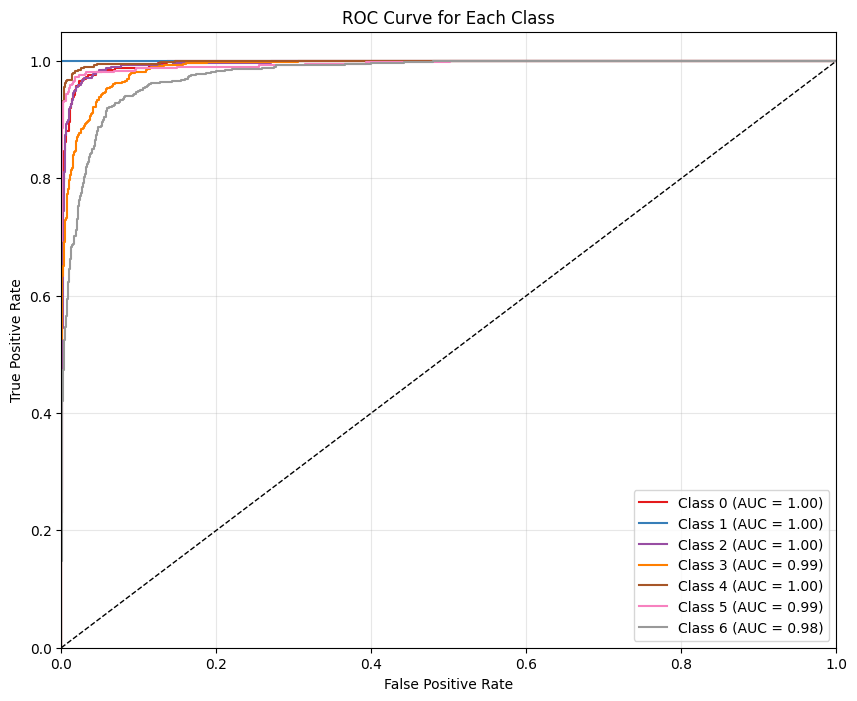

In [ ]:
# Part five: Evaluation and Choice of Prediction Model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


n_classes = 7

clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
clf.fit(X_train_scaled, y_train)

y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_score = clf.decision_function(X_test_scaled)  # 对于OneVsRestClassifier，使用decision_function

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
